# Transfer Learning

Source: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/transfer-learning/Transfer_Learning_Exercise.ipynb

## Download data

In [1]:
from pathlib import Path
import requests

In [2]:
# !mkdir data

In [3]:
DATASET_URL = 'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip'

SAVE_PATH = Path('./data/flowers.zip')

In [4]:
if not SAVE_PATH.exists():
    content = requests.get(DATASET_URL).content
    with open(SAVE_PATH, 'wb') as f:
        f.write(content)

In [5]:
# !unzip ./data/flowers.zip flower_photos/* -d ./data/

In [6]:
TRAIN_DIR = Path('./data/flower_photos/train/')
TEST_DIR = Path('./data/flower_photos/test/')

In [7]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms

In [8]:
if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'
else:
    print('CUDA is available!  Training on GPU ...')
    device = 'cuda:0'

CUDA is not available.  Training on CPU ...


In [9]:
# device = 'cpu'

In [10]:
!ls data/flower_photos/

LICENSE.txt  test  train


In [11]:
!ls data/flower_photos/train
!ls data/flower_photos/test

daisy  dandelion  roses  sunflowers  tulips
daisy  dandelion  roses  sunflowers  tulips


In [12]:
classes = 'daisy  dandelion  roses  sunflowers  tulips'.split()

## Setup DataLoader

In [13]:
tfms = transforms.Compose([transforms.RandomResizedCrop((224,224)), transforms.ToTensor()])

In [14]:
train_ds = ImageFolder(TRAIN_DIR, transform=tfms)
test_ds = ImageFolder(TEST_DIR, transform=tfms)

In [15]:
print('Num training images: ', len(train_ds))
print('Num test images: ', len(test_ds))

Num training images:  3130
Num test images:  540


In [16]:
bs = 16

train_dl = DataLoader(train_ds, shuffle=True, batch_size=bs)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=2*bs)

## Visualize 

In [17]:
import matplotlib.pyplot as plt
import numpy as np

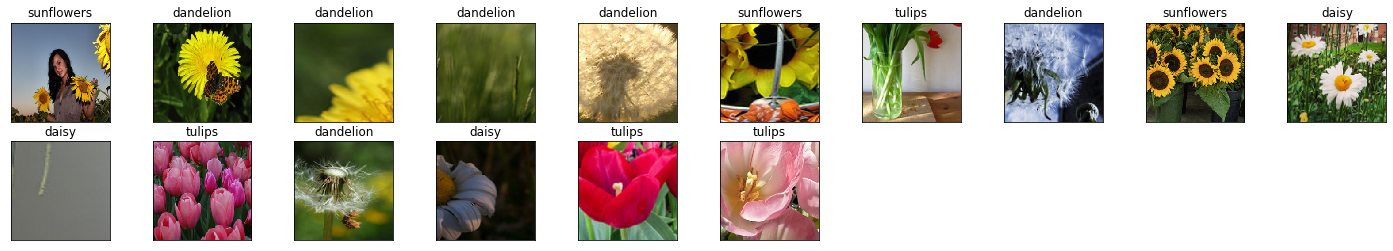

In [18]:
# obtain one batch of training images
dataiter = iter(train_dl)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## VGG Pretrained

In [19]:
vgg16 = torchvision.models.vgg.vgg16(pretrained=True, progress=True)

In [20]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


## Freeze all layers

In [26]:
for p in vgg16.parameters():
    p.requires_grad = False

# Double check

for p in vgg16.parameters():
    if p.requires_grad == True:
        print("Not frozen: ", p)

In [27]:
import torch.nn as nn

In [28]:
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, len(classes))

In [29]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)

In [30]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
opt =  optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [31]:
epochs = 2

In [32]:
def loss_batch(model, loss_function, xb, yb, opt=None):
    loss = loss_function(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(yb)

In [33]:
def fit(epochs, model, device, loss_function, opt, train_dl, valid_dl):
    model.to(device)
    for epoch in range(epochs):
        
        model.train()
        for i, (xb, yb) in enumerate(train_dl, start=1):
            xb = xb.to(device)
            yb = yb.to(device)
            l, _  = loss_batch(model, loss_function, xb, yb, opt)
            if i%10==0:
                print(f"Epoch: {epoch} Batch: {i}/{len(train_dl.dataset) // train_dl.batch_size} Loss: {l}")

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_function, xb.to(device), yb.to(device)) for xb, yb in test_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(f"Epoch: {epoch}, Val Loss: {val_loss}")

In [34]:
device

'cpu'

In [35]:
fit(epochs, vgg16, device, criterion, opt, train_dl, test_dl)

Epoch: 0 Batch: 10/195 Loss: 1.7852290868759155
Epoch: 0 Batch: 20/195 Loss: 1.3780179023742676
Epoch: 0 Batch: 30/195 Loss: 1.4601093530654907
Epoch: 0 Batch: 40/195 Loss: 1.3917264938354492
Epoch: 0 Batch: 50/195 Loss: 1.2725422382354736
Epoch: 0 Batch: 60/195 Loss: 1.0820872783660889
Epoch: 0 Batch: 70/195 Loss: 1.238998532295227
Epoch: 0 Batch: 80/195 Loss: 1.06640625
Epoch: 0 Batch: 90/195 Loss: 1.0259860754013062
Epoch: 0 Batch: 100/195 Loss: 1.0958069562911987
Epoch: 0 Batch: 110/195 Loss: 1.0399794578552246
Epoch: 0 Batch: 120/195 Loss: 1.1516685485839844
Epoch: 0 Batch: 130/195 Loss: 1.1975417137145996
Epoch: 0 Batch: 140/195 Loss: 0.9590790867805481
Epoch: 0 Batch: 150/195 Loss: 1.030032992362976
Epoch: 0 Batch: 160/195 Loss: 1.1987321376800537
Epoch: 0 Batch: 170/195 Loss: 0.9158247709274292
Epoch: 0 Batch: 180/195 Loss: 0.8715803027153015
Epoch: 0 Batch: 190/195 Loss: 1.0534133911132812
Epoch: 0, Val Loss: 0.9073693390245791
Epoch: 1 Batch: 10/195 Loss: 0.7567100524902344
E

In [36]:
# obtain one batch of test images
dataiter = iter(test_dl)
images, labels = dataiter.next()
images.numpy()

vgg16.cpu()
output = vgg16(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy())

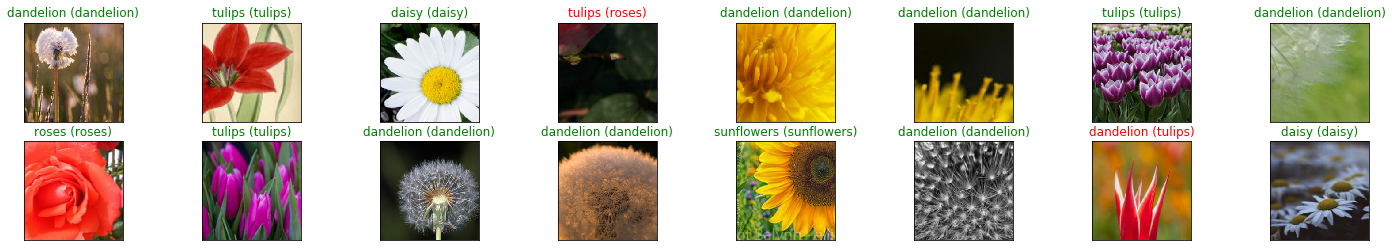

In [37]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(bs):
    ax = fig.add_subplot(2, bs/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Accuracy

In [45]:
len(test_dl), len(test_dl.dataset)

(17, 540)

In [44]:
vgg16.eval()
with torch.no_grad():
    correct = 0
    seen = 0
    for xb, yb in test_dl:
        preds = vgg16(xb)
        preds = torch.argmax(preds, axis=1)
        correct += preds.eq(yb).float().sum()
        seen += len(xb)
    print(f"Accuracy: {correct/seen}")

Accuracy: 0.7759259343147278


In [41]:
preds.shape, yb.shape

(torch.Size([32]), torch.Size([32]))